In [1]:
import segmentation_models as sm
import tensorflow as tf
import numpy as np
import glob
import os
import cv2


# self-written scripts
import sys
sys.path.insert(0, 'Python_Scripts')

import data_preparation_cnn

LEARNING_RATE = 0.005
OPTIMIZER = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

Segmentation Models: using `keras` framework.


/Users/fabioteichmann/neuefische/projects/CapstoneProject_SteelDefectDetection/.venv/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [2]:
def get_images(class_id, size_x, size_y):
    images = []
    path_suffix = 'c' + str(class_id) + '/'

    for directory_path in glob.glob('data/segmentation/test/' + path_suffix):
        for img_path in sorted(glob.glob(os.path.join(directory_path, "*.jpg"))):
            #print(img_path)
            #break
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
            img = cv2.resize(img, (size_y, size_x))
            # img = img/255
            #print(img)
            #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            images.append(img)
            #train_labels.append(label)
    #Convert list to array for machine learning processing        
    images = np.array(images)
    
    return images

In [3]:
def get_masks(class_id, size_x, size_y):
    images = []
    path_suffix = 'c' + str(class_id) + '/'

    for directory_path in glob.glob('data/segmentation/test_mask/' + path_suffix):
        for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
            #print(img_path)
            #break
            img = cv2.imread(img_path, 0)       
            img = cv2.resize(img, (size_y, size_x))
            #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            images.append(img)
            #train_labels.append(label)
    #Convert list to array for machine learning processing        
    images = np.array(images)
    
    return images

In [4]:
def prepare_input_variables(class_id, train_images, train_masks, size_x, size_y):
    # get preprocessing for `EfficientNetB5`
    preprocess_input = sm.get_preprocessing('efficientnetb5')
    
    # prepare variables
    x_train = preprocess_input(train_images)
    y_train = np.expand_dims(train_masks, axis=3)
    # y_train = y_train/255

    x_val = get_images(class_id=class_id, size_x=size_x, size_y=size_y)
    x_val = preprocess_input(x_val)
    y_val = get_masks(class_id=class_id, size_x=size_x, size_y=size_y)
    y_val = np.expand_dims(y_val, axis=3) #May not be necessary.. leftover from previous code 
    # y_val = y_val / 255

    return x_train, y_train, x_val, y_val

In [5]:
def build_compiled_model(size_x, size_y, metric_for_model):
    # set the correct framework for the model to work
    sm.set_framework('tf.keras')
    sm.framework()
    
    # define model
    model = sm.Unet('efficientnetb5',
                    input_shape=(size_x, size_y, 3),
                    classes=1,
                    activation='sigmoid',
                    encoder_weights='imagenet',
                    encoder_freeze=True
                   )
    if metric_for_model == 'dice':
        model.compile(optimizer=OPTIMIZER, loss=dice_loss, metrics=[dice_coef])
    else:
        model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=[metric_for_model])
    
    return model

In [6]:
def get_history_from_mask_model(class_id, size_x, size_y, metric_for_model, epochs):
    tf.keras.backend.clear_session()
    # load images and masks as input for model
    train_images, train_masks = data_preparation_cnn.get_resized_image_and_mask_lists(class_id=class_id, 
                                                                              size_x=size_x, 
                                                                              size_y=size_y)

    # build input variables for model
    x_train, y_train, x_val, y_val = prepare_input_variables(class_id, 
                                                             train_images, 
                                                             train_masks, 
                                                             size_x, 
                                                             size_y)
        
    # create a compiled model
    model = build_compiled_model(size_x, size_y, metric_for_model)
    
    print(f'beginning training with masks')
    # fit the model
    history = model.fit(x_train, 
                        y_train,
                        batch_size=32, 
                        epochs=epochs,
                        verbose=True,
                        validation_data=(x_val, y_val)
                       )
    
    # predictions = model.predict(x_val)
    
    # save model
    model_name = 'models/class' + str(class_id) + '_mask_generator.h5'
    model.save(model_name)
    
    return history, model

In [7]:
from keras.losses import binary_crossentropy

In [8]:
def dice_coef(y_true,y_pred):
    y_true_f=tf.reshape(tf.dtypes.cast(y_true, tf.float32),[-1])
    y_pred_f=tf.reshape(tf.dtypes.cast(y_pred, tf.float32),[-1])
    intersection=tf.reduce_sum(y_true_f*y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)
def dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    return (1-dice_coef(y_true, y_pred))
def bce_dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    return binary_crossentropy(y_true, y_pred) + (1-dice_coef(y_true, y_pred))

In [9]:
def build_mask_generating_models(size_x, size_y, metric_for_model, epochs):
    
    losses = []
    losses_val = []
    
    metric_results = []
    metric_results_val = []
    
    predictions = {}
    models = {}
    
    for class_id in [1,2,3,4]:
        print(f'building model for defect class {class_id}...')
        
        
        # extract the history for each model
        history, model = get_history_from_mask_model(class_id, size_x, size_y, metric_for_model, epochs)
        
        losses.append(history.history['loss'])
        losses_val.append(history.history['val_loss'])
        if metric_for_model == 'dice':
            pass
        else:
            metric_results = history.history[metric_for_model]
            metric_results_val = history.history['val_' + metric_for_model]
        
        # predictions[str(class_id)] = pred
        models[str(class_id)] = model
        
        print('model successfully generated and saved to file!')
        print('-----'*10)
        print()
    
    return models
        

In [10]:

# PARAMETERS
SIZE_X = 128
SIZE_Y = 512
EPOCHS = 20

In [ ]:
models = build_mask_generating_models(SIZE_X, SIZE_Y, 'dice', EPOCHS)

In [ ]:
# predictions

In [ ]:
models

In [11]:
import keras
import matplotlib.pyplot as plt

# SIZE_X = 128
# SIZE_Y = 256

In [ ]:
model1 = keras.models.load_model('models/class1_mask_generator.h5', compile=False)
model2 = keras.models.load_model('models/class2_mask_generator.h5', compile=False)
model3 = keras.models.load_model('models/class3_mask_generator.h5', compile=False)
model4 = keras.models.load_model('models/class4_mask_generator.h5', compile=False)

In [ ]:
model1.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef])
model2.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef])
model3.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef])
model4.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef])

In [ ]:
preprocess_input = sm.get_preprocessing('efficientnetb5')

images1 = preprocess_input(get_images(4, SIZE_X, SIZE_Y))
masks1 = get_masks(4, SIZE_X, SIZE_Y)

In [ ]:
masks[0]

In [ ]:
# test_img2 = np.expand_dims(test_img2, axis=0).shape

In [ ]:
plt.figure(figsize=(6,3))
plt.imshow(images1[0])

In [ ]:
plt.figure(figsize=(6,3))
plt.imshow(masks1[0])

In [ ]:
model1 = models['1']
model2 = models['2']
model3 = models['3']
model4 = models['4']

In [ ]:
prediction1 = model1.predict(images1)
prediction2 = model2.predict(images1)
prediction3 = model3.predict(images1)
prediction4 = model4.predict(images1)

In [ ]:
# (prediction1[0]==prediction1[1]).sum()

In [ ]:
number_images = 5

random_index = np.round(np.random.rand(number_images) * len(prediction3)) + 1
print(random_index)

for i in range(number_images):
    # random_index = 'random_index_' + str(i+1)
    # print(random_index)
    # file_path_to_image = false_predicted_images['FilePath'][random_index[i]]
    # class_id = false_predicted_images['ClassId'][random_index[i]]
    # image_id = false_predicted_images['ImageId'][random_index[i]]
    # class_id_pred = int(false_predicted_images['ClassId_predicted'][random_index[i]])
    
    img = prediction3[int(random_index[i])]
    plt.figure(figsize=(18, 10))
    ax = plt.subplot(number_images, 1, i + 1)
    plt.imshow(img)
    # plt.title(f'Image ID: {image_id} | True ClassId: {class_id} | Predicted ClassId: {class_id_pred}', fontsize=16);
    plt.axis("off")

In [ ]:
# plt.figure(figsize=(16,3))
saved_model = False
class_id = 4

nrows = 10
ncols = 6
rows = list(range(nrows))
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3,2*nrows))

# print(axs)

if saved_model:
    fig.suptitle(f'Performance of Mask Model from saved Model | Epochs: {EPOCHS}', fontsize=16)
else:
    fig.suptitle(f'Performance of Mask Model from fitted Model | Epochs: {EPOCHS}', fontsize=16)


for row, a, b, c, d, e, f in zip(rows, images1, masks1, prediction1, prediction2, prediction3, prediction4):
    # ax = plt.subplot(row, ncols, 1+(row-1)*6)
    axs[row, 0].imshow(a)
    # ax.set_axis_off()
    if row == 0:
        axs[row, 0].set_title(f'true image')
    axs[row, 0].set_ylabel(f'ClassId = {class_id}', fontsize=14)
    axs[row, 0].set_xticks([])
    axs[row, 0].set_yticks([])
    # plt.imshow(a)

    # ax = plt.subplot(row,ncols, 2)
    axs[row, 1].imshow(b)
    if row == 0:
        axs[row, 1].set_title('true mask')
    axs[row, 1].set_axis_off()
    
    # plt.imshow(b)

    # ax = plt.subplot(row,ncols, 3)
    axs[row, 2].imshow(c)
    if row == 0:
        axs[row, 2].set_title('mask model 1')
    axs[row, 2].set_axis_off()
    # plt.imshow(c)

    # ax = plt.subplot(row,ncols, 4)
    axs[row, 3].imshow(d)
    if row == 0:
        axs[row, 3].set_title('mask model 2')
    axs[row, 3].set_axis_off()
    # plt.imshow(d)

    # ax = plt.subplot(row,ncols, 5)
    axs[row, 4].imshow(e)
    if row == 0:
        axs[row, 4].set_title('mask model 3')
    axs[row, 4].set_axis_off()
    # plt.imshow(e)

    # ax = plt.subplot(row,ncols, 6)
    axs[row, 5].imshow(f)
    if row == 0:
        axs[row, 5].set_title('mask model 4')
    axs[row, 5].set_axis_off()
    # plt.imshow(f)
    #break
    if row == nrows:
        break

In [ ]:
np.unique(masks1[0])

In [ ]:
temp = get_masks(4,1600,256)

In [ ]:
np.unique(temp[1])

---

## Without Function

### Defect 1

In [12]:
size_x=SIZE_X
size_y=SIZE_Y
metric_for_model='dice'
epochs=EPOCHS

In [13]:
tf.keras.backend.clear_session()

train_images, train_masks = data_preparation_cnn.get_resized_image_and_mask_lists(class_id=1, 
                                                                              size_x=size_x, 
                                                                              size_y=size_y)

# build input variables for model
x_train, y_train, x_val, y_val = prepare_input_variables(1, 
                                                         train_images, 
                                                         train_masks, 
                                                         size_x, 
                                                         size_y)

# create a compiled model
model1 = build_compiled_model(size_x, size_y, metric_for_model)

print(f'beginning training with masks')
# fit the model
history1 = model1.fit(x_train, 
                    y_train,
                    batch_size=32, 
                    epochs=epochs,
                    verbose=True,
                    validation_data=(x_val, y_val)
                   )

2022-02-22 23:11:13.503827: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-22 23:11:13.503922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
beginning training with masks


2022-02-22 23:11:15.951194: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2022-02-22 23:11:22.334508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 0.7250 - dice_coef: 0.2819 

2022-02-22 23:20:03.081242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 542s 16s/step - loss: 0.7250 - dice_coef: 0.2819 - val_loss: 0.9766 - val_dice_coef: 0.0231
Epoch 2/20
32/32 [==============================] - 514s 16s/step - loss: 0.4634 - dice_coef: 0.5339 - val_loss: 0.9633 - val_dice_coef: 0.0363
Epoch 3/20
32/32 [==============================] - 516s 16s/step - loss: 0.4137 - dice_coef: 0.5860 - val_loss: 0.9387 - val_dice_coef: 0.0605
Epoch 4/20
32/32 [==============================] - 522s 16s/step - loss: 0.3922 - dice_coef: 0.6068 - val_loss: 0.9048 - val_dice_coef: 0.0934
Epoch 5/20
32/32 [==============================] - 513s 16s/step - loss: 0.3636 - dice_coef: 0.6360 - val_loss: 0.6198 - val_dice_coef: 0.3764
Epoch 6/20
32/32 [==============================] - 516s 16s/step - loss: 0.3485 - dice_coef: 0.6528 - val_loss: 0.5125 - val_dice_coef: 0.4868
Epoch 7/20
32/32 [==============================] - 521s 16s/step - loss: 0.3183 - dice_coef: 0.6806 - val_loss: 0.4413 - val_dice_coef: 0.5595
Epo

### Defect 2

In [14]:
tf.keras.backend.clear_session()
train_images, train_masks = data_preparation_cnn.get_resized_image_and_mask_lists(class_id=2, 
                                                                              size_x=size_x, 
                                                                              size_y=size_y)

# build input variables for model
x_train, y_train, x_val, y_val = prepare_input_variables(2, 
                                                         train_images, 
                                                         train_masks, 
                                                         size_x, 
                                                         size_y)

# create a compiled model
model2 = build_compiled_model(size_x, size_y, metric_for_model)

print(f'beginning training with masks')
# fit the model
history2 = model2.fit(x_train, 
                    y_train,
                    batch_size=32, 
                    epochs=epochs,
                    verbose=True,
                    validation_data=(x_val, y_val)
                   )

beginning training with masks
Epoch 1/20


2022-02-23 02:04:13.195374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 0.6860 - dice_coef: 0.3173 

2022-02-23 02:12:55.548576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 536s 16s/step - loss: 0.6860 - dice_coef: 0.3173 - val_loss: 0.9641 - val_dice_coef: 0.0347
Epoch 2/20
32/32 [==============================] - 525s 16s/step - loss: 0.4461 - dice_coef: 0.5572 - val_loss: 0.9167 - val_dice_coef: 0.0809
Epoch 3/20
32/32 [==============================] - 532s 17s/step - loss: 0.3757 - dice_coef: 0.6259 - val_loss: 0.6708 - val_dice_coef: 0.3241
Epoch 4/20
32/32 [==============================] - 530s 17s/step - loss: 0.3283 - dice_coef: 0.6708 - val_loss: 0.4923 - val_dice_coef: 0.4977
Epoch 5/20
32/32 [==============================] - 535s 17s/step - loss: 0.2981 - dice_coef: 0.7011 - val_loss: 0.4687 - val_dice_coef: 0.5211
Epoch 6/20
32/32 [==============================] - 530s 16s/step - loss: 0.2590 - dice_coef: 0.7412 - val_loss: 0.4901 - val_dice_coef: 0.5023
Epoch 7/20
32/32 [==============================] - 527s 16s/step - loss: 0.2438 - dice_coef: 0.7536 - val_loss: 0.5528 - val_dice_coef: 0.4177
Epo

### Defect 3

In [15]:
tf.keras.backend.clear_session()
train_images, train_masks = data_preparation_cnn.get_resized_image_and_mask_lists(class_id=3, 
                                                                              size_x=size_x, 
                                                                              size_y=size_y)

# build input variables for model
x_train, y_train, x_val, y_val = prepare_input_variables(3, 
                                                         train_images, 
                                                         train_masks, 
                                                         size_x, 
                                                         size_y)

# create a compiled model
model3 = build_compiled_model(size_x, size_y, metric_for_model)

print(f'beginning training with masks')
# fit the model
history3 = model3.fit(x_train, 
                    y_train,
                    batch_size=32, 
                    epochs=epochs,
                    verbose=True,
                    validation_data=(x_val, y_val)
                   )

beginning training with masks
Epoch 1/20


2022-02-23 05:02:59.164162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 0.5454 - dice_coef: 0.4578 

2022-02-23 05:12:18.132207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 640s 20s/step - loss: 0.5454 - dice_coef: 0.4578 - val_loss: 0.8822 - val_dice_coef: 0.1171
Epoch 2/20
32/32 [==============================] - 606s 19s/step - loss: 0.3939 - dice_coef: 0.6084 - val_loss: 0.7993 - val_dice_coef: 0.1997
Epoch 3/20
32/32 [==============================] - 604s 19s/step - loss: 0.3598 - dice_coef: 0.6419 - val_loss: 0.5919 - val_dice_coef: 0.4075
Epoch 4/20
32/32 [==============================] - 614s 19s/step - loss: 0.3339 - dice_coef: 0.6669 - val_loss: 0.3914 - val_dice_coef: 0.6074
Epoch 5/20
32/32 [==============================] - 608s 19s/step - loss: 0.3061 - dice_coef: 0.6951 - val_loss: 0.3770 - val_dice_coef: 0.6214
Epoch 6/20
32/32 [==============================] - 614s 19s/step - loss: 0.2890 - dice_coef: 0.7086 - val_loss: 0.4001 - val_dice_coef: 0.5984
Epoch 7/20
32/32 [==============================] - 610s 19s/step - loss: 0.2806 - dice_coef: 0.7221 - val_loss: 0.3627 - val_dice_coef: 0.6354
Epo

### Defect 4

In [16]:
tf.keras.backend.clear_session()
train_images, train_masks = data_preparation_cnn.get_resized_image_and_mask_lists(class_id=4, 
                                                                              size_x=size_x, 
                                                                              size_y=size_y)

# build input variables for model
x_train, y_train, x_val, y_val = prepare_input_variables(4, 
                                                         train_images, 
                                                         train_masks, 
                                                         size_x, 
                                                         size_y)

# create a compiled model
model4 = build_compiled_model(size_x, size_y, metric_for_model)

print(f'beginning training with masks')
# fit the model
history4 = model4.fit(x_train, 
                    y_train,
                    batch_size=32, 
                    epochs=epochs,
                    verbose=True,
                    validation_data=(x_val, y_val)
                   )

beginning training with masks
Epoch 1/20


2022-02-23 08:27:18.294433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 0.3821 - dice_coef: 0.6188 

2022-02-23 08:36:54.484135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 601s 18s/step - loss: 0.3821 - dice_coef: 0.6188 - val_loss: 0.8490 - val_dice_coef: 0.1486
Epoch 2/20
32/32 [==============================] - 573s 18s/step - loss: 0.2458 - dice_coef: 0.7530 - val_loss: 0.8293 - val_dice_coef: 0.1683
Epoch 3/20
32/32 [==============================] - 575s 18s/step - loss: 0.2148 - dice_coef: 0.7837 - val_loss: 0.3435 - val_dice_coef: 0.6568
Epoch 4/20
32/32 [==============================] - 567s 18s/step - loss: 0.1962 - dice_coef: 0.8022 - val_loss: 0.3101 - val_dice_coef: 0.6911
Epoch 5/20
32/32 [==============================] - 574s 18s/step - loss: 0.1828 - dice_coef: 0.8180 - val_loss: 0.3367 - val_dice_coef: 0.6641
Epoch 6/20
32/32 [==============================] - 574s 18s/step - loss: 0.1721 - dice_coef: 0.8265 - val_loss: 0.2722 - val_dice_coef: 0.7292
Epoch 7/20
32/32 [==============================] - 579s 18s/step - loss: 0.1653 - dice_coef: 0.8357 - val_loss: 0.2813 - val_dice_coef: 0.7189
Epo

In [ ]:
plt.imshow(prediction4_[0])

In [358]:
preprocess_input = sm.get_preprocessing('efficientnetb5')
images2 = preprocess_input(get_images(1,SIZE_X,SIZE_Y))
images2_ = get_images(1,SIZE_X,SIZE_Y)
masks2 = get_masks(1,SIZE_X,SIZE_Y)

In [359]:
prediction1_ = model1.predict(images2)
prediction2_ = model2.predict(images2)
prediction3_ = model3.predict(images2)
prediction4_ = model4.predict(images2)

2022-02-24 13:23:03.717082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 13:23:54.265822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 13:24:40.201069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 13:25:27.504270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [ ]:
prediction1_.shape

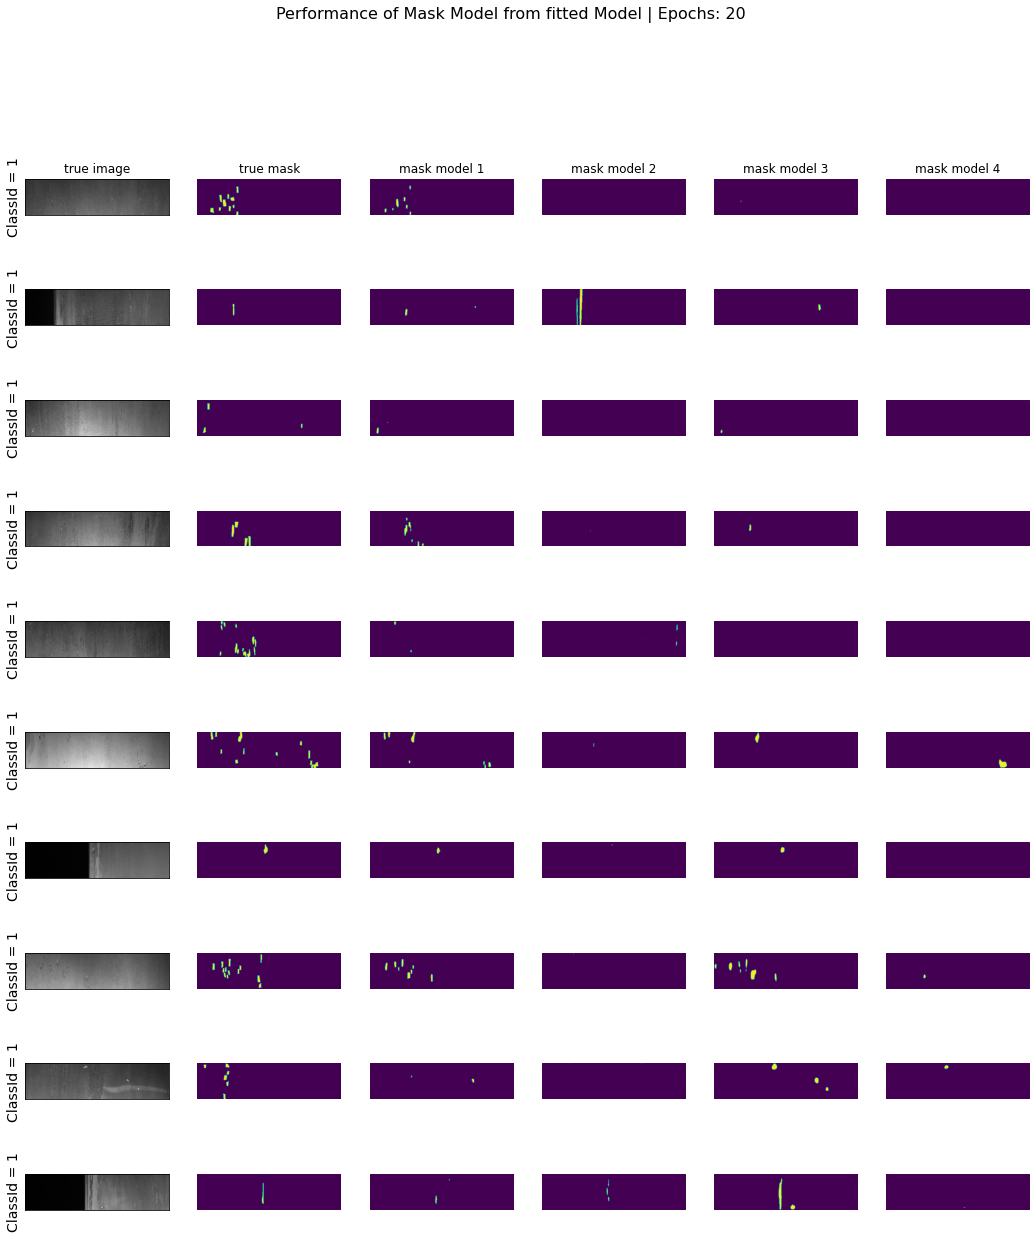

In [360]:
# plt.figure(figsize=(16,3))
saved_model = False
class_id = 1

nrows = 10
ncols = 6
rows = list(range(nrows))
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3,2*nrows))

# print(axs)

if saved_model:
    fig.suptitle(f'Performance of Mask Model from saved Model | Epochs: {EPOCHS}', fontsize=16)
else:
    fig.suptitle(f'Performance of Mask Model from fitted Model | Epochs: {EPOCHS}', fontsize=16)


for row, a, b, c, d, e, f in zip(rows, images2_, masks2, prediction1_, prediction2_, prediction3_, prediction4_):
    # ax = plt.subplot(row, ncols, 1+(row-1)*6)
    axs[row, 0].imshow(a)
    # ax.set_axis_off()
    if row == 0:
        axs[row, 0].set_title(f'true image')
    axs[row, 0].set_ylabel(f'ClassId = {class_id}', fontsize=14)
    axs[row, 0].set_xticks([])
    axs[row, 0].set_yticks([])
    # plt.imshow(a)

    # ax = plt.subplot(row,ncols, 2)
    axs[row, 1].imshow(b)
    if row == 0:
        axs[row, 1].set_title('true mask')
    axs[row, 1].set_axis_off()
    
    # plt.imshow(b)

    # ax = plt.subplot(row,ncols, 3)
    axs[row, 2].imshow(c)
    if row == 0:
        axs[row, 2].set_title('mask model 1')
    axs[row, 2].set_axis_off()
    # plt.imshow(c)

    # ax = plt.subplot(row,ncols, 4)
    axs[row, 3].imshow(d)
    if row == 0:
        axs[row, 3].set_title('mask model 2')
    axs[row, 3].set_axis_off()
    # plt.imshow(d)

    # ax = plt.subplot(row,ncols, 5)
    axs[row, 4].imshow(e)
    if row == 0:
        axs[row, 4].set_title('mask model 3')
    axs[row, 4].set_axis_off()
    # plt.imshow(e)

    # ax = plt.subplot(row,ncols, 6)
    axs[row, 5].imshow(f)
    if row == 0:
        axs[row, 5].set_title('mask model 4')
    axs[row, 5].set_axis_off()
    # plt.imshow(f)
    #break
    if row == nrows:
        break

(128, 512, 3)


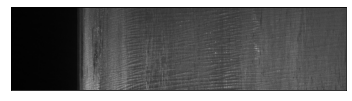

In [361]:
p_img = images2_[1]
plt.imshow(p_img)

print(p_img.shape)
plt.xticks([])
plt.yticks([])
plt.imsave('plot_images/img_class3.png', p_img);

(128, 512, 3)


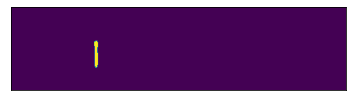

In [362]:
mask = masks2[1]
plt.imshow(mask)

print(p_img.shape)
plt.xticks([])
plt.yticks([])
plt.imsave('plot_images/mask_class3.png', mask);

(128, 512, 1)


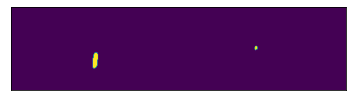

In [363]:
p_pred1 = prediction1_[1]
plt.imshow(p_pred1)
print(p_pred1.shape)
plt.xticks([])
plt.yticks([])
plt.savefig('plot_images/mask_class3_model1.png', bbox_inches='tight',pad_inches=0);

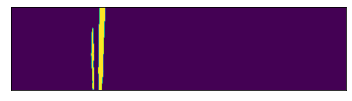

In [364]:
p_pred2 = prediction2_[1]
plt.imshow(p_pred2)
plt.xticks([])
plt.yticks([])
plt.savefig('plot_images/mask_class3_model2.png', bbox_inches='tight',pad_inches=0);

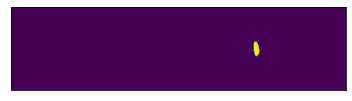

In [365]:
p_pred3 = prediction3_[1]
plt.imshow(p_pred3)
plt.xticks([])
plt.yticks([])
plt.savefig('plot_images/mask_class3_model3.png', bbox_inches='tight',pad_inches=0);

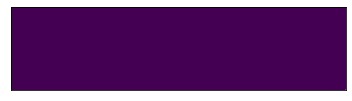

In [366]:
p_pred4 = prediction4_[1]
plt.imshow(p_pred4)
plt.xticks([])
plt.yticks([])
plt.savefig('plot_images/mask_class3_model4.png', bbox_inches='tight',pad_inches=0);

In [270]:
model1.save_weights('models/class_1_20e_LR005.h5')
model2.save_weights('models/class_2_20e_LR005.h5')
model3.save_weights('models/class_3_20e_LR005.h5')
model4.save_weights('models/class_4_20e_LR005.h5')

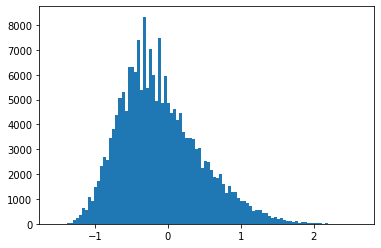

In [177]:
plt.hist(images2[2].flatten(), bins=100);

In [351]:
def get_pred_dict(models, images):
    print('making predictions...')
    tf.keras.backend.clear_session()

    prediction1_ = models[0].predict(images)
    prediction2_ = models[1].predict(images)
    prediction3_ = models[2].predict(images)
    prediction4_ = models[3].predict(images)

    pred_dict = {
        '1': prediction1_,
        '2': prediction2_,
        '3': prediction3_,
        '4': prediction4_
    }
    return pred_dict

In [137]:
pred_dict = get_pred_dict([model1, model2, model3, model4], images2)

making predictions...


In [131]:
a = pred_dict.keys()

In [133]:
for i in a:
    print(i)
a

1
2
3
4


dict_keys(['1', '2', '3', '4'])

In [249]:
b = list(a)
c = b.pop(1)

for char in b:
    # print(char)
    c += ',' + char
c.split(',')

['2', '1', '3', '4']

In [45]:
# pred_dict['1'][0]

In [356]:
def calculate_sums(pred_dict, class_id):
    class1_max_pixel = (15000 / (256 * 1600)) * (SIZE_X * SIZE_Y)
    class2_max_pixel = (8000 / (256 * 1600)) * (SIZE_X * SIZE_Y)
    class3_max_pixel = (100000 / (256 * 1600)) * (SIZE_X * SIZE_Y)
    class4_max_pixel = (75000 / (256 * 1600)) * (SIZE_X * SIZE_Y)


    sums = {}
    temp = []
    for key in pred_dict.keys():
        # print(type(key))
        for prediction in range(len(pred_dict[key])):
            if class_id == 1 and key != '1':
                # print('class 1')
                if np.round(pred_dict[key][prediction].sum()) > class1_max_pixel:
                    temp.append(0)
                else:
                    temp.append(np.round(pred_dict[key][prediction]).sum())
                    
            elif class_id == 2 and key != '2':
                if np.round(pred_dict[key][prediction].sum()) > class2_max_pixel:
                    temp.append(0)
                else:
                    temp.append(np.round(pred_dict[key][prediction]).sum())
                    
            elif class_id == 3 and key != '3':
                if np.round(pred_dict[key][prediction].sum()) > class3_max_pixel:
                    temp.append(0)
                else:
                    temp.append(np.round(pred_dict[key][prediction]).sum())
                    
            elif class_id == 4 and key != '4':
                if np.round(pred_dict[key][prediction].sum()) > class4_max_pixel:
                    temp.append(0)
                else:
                    temp.append(np.round(pred_dict[key][prediction]).sum())
                    
            else:
                temp.append(np.round(pred_dict[key][prediction]).sum())
                            
        sums[key] = temp
        temp = []
    
    return sums

In [168]:
sums = calculate_sums(pred_dict)

In [49]:
# sums

In [349]:
import pandas as pd

def build_df(sums, class_id):
    df = pd.DataFrame()
    df = df.assign(a=sums['1']).assign(b=sums['2']).assign(c=sums['3']).assign(d=sums['4'])
    if class_id == 1:
        df['class2'] = (df.a < df.b).astype(int)
        df['class3'] = (df.a < df.c).astype(int)
        df['class4'] = (df.a < df.d).astype(int)
    if class_id == 2:
        df['class2'] = (df.b < df.a).astype(int)
        df['class3'] = (df.b < df.c).astype(int)
        df['class4'] = (df.b < df.d).astype(int)
    if class_id == 3:
        df['class2'] = (df.c < df.b).astype(int)
        df['class3'] = (df.c < df.a).astype(int)
        df['class4'] = (df.c < df.d).astype(int)
    if class_id == 4:
        df['class2'] = (df.d < df.b).astype(int)
        df['class3'] = (df.d < df.c).astype(int)
        df['class4'] = (df.d < df.a).astype(int)
    
    return df

In [169]:
df = build_df(sums, 1)

In [276]:
def calculate_accuracy(df):
    print('calculating accuracy...')
    return 1 - ((df.class2.sum() + df.class3.sum() + df.class4.sum()) / len(df))
    

In [170]:
calculate_accuracy(df)

calculating accuracy...


0.3048327137546468

- maximum Fehlerpixel aus EDA
- prozentual zu resize
- oberer Threshold

In [350]:
def get_images_for_prediction(class_id):
    preprocess_input = sm.get_preprocessing('efficientnetb5')
    
    images = get_images(class_id,SIZE_X,SIZE_Y)
    images = preprocess_input(images)
    
    return images

In [354]:
def get_accuracy_for_class(models, class_id):
    print(f'Calculating accuracy for defect class {class_id}:')
    images = get_images_for_prediction(class_id)
    
    pred_dict = get_pred_dict(models, images)
    
    sums = calculate_sums(pred_dict, class_id)
    
    df = build_df(sums, class_id)
    
    accuracy = calculate_accuracy(df)
    
    return accuracy

In [279]:
accuracies = []
models = [model1, model2, model3, model4]

for class_id in [1,2,3,4]:
    accuracies.append(get_accuracy_for_class(models, class_id))

print()
print('-----'*12)
print(accuracies)

Calculating accuracy for defect class 1:
making predictions...
calculating accuracy...
Calculating accuracy for defect class 2:
making predictions...
calculating accuracy...
Calculating accuracy for defect class 3:
making predictions...
calculating accuracy...
Calculating accuracy for defect class 4:
making predictions...
calculating accuracy...

------------------------------------------------------------
[0.3234200743494424, 0.7837837837837838, 0.554333764553687, -0.25]


In [278]:
models

---

## Load Models

In [346]:
model1_ = build_compiled_model(size_x, size_y, 'dice')
model2_ = build_compiled_model(size_x, size_y, 'dice')
model3_ = build_compiled_model(size_x, size_y, 'dice')
model4_ = build_compiled_model(size_x, size_y, 'dice')

In [347]:
savedModel1 = model1_.load_weights('models/class_1_20e_LR005.h5')
savedModel2 = model2_.load_weights('models/class_2_20e_LR005.h5')
savedModel3 = model3_.load_weights('models/class_3_20e_LR005.h5')
savedModel4 = model4_.load_weights('models/class_4_20e_LR005.h5')

In [342]:
pred1_ = model1_.predict(images2)
pred1_ = model1_.predict(images2)
pred1_ = model1_.predict(images2)
pred1_ = model1_.predict(images2)

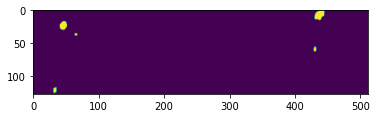

In [345]:
plt.imshow(pred1_[1])

In [ ]:
pred_dict = get_pred_dict([model1_, model2_, model3_, model4_], images2)

In [357]:
accuracies = []
models_ = [model1_, model2_, model3_, model4_]

for class_id in [1,2,3,4]:
    accuracies.append(get_accuracy_for_class(models_, class_id))

print()
print('-----'*12)
print(accuracies)

Calculating accuracy for defect class 1:
making predictions...


2022-02-24 12:01:20.704419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 12:02:06.397802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 12:02:47.640336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 12:03:30.564871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


calculating accuracy...
Calculating accuracy for defect class 2:
making predictions...


2022-02-24 12:04:18.520022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 12:04:53.999492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 12:05:22.099848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 12:05:53.820102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


calculating accuracy...
Calculating accuracy for defect class 3:
making predictions...


2022-02-24 12:07:05.213411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 12:09:44.523566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 12:12:35.852707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 12:15:15.456214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


calculating accuracy...
Calculating accuracy for defect class 4:
making predictions...


2022-02-24 12:17:22.496953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 12:18:04.618409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 12:18:46.275510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-24 12:19:26.065449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


calculating accuracy...

------------------------------------------------------------
[0.3234200743494424, 0.8108108108108107, 0.8473479948253557, 0.7208333333333333]


In [21]:
sums = {}
temp = []
for i in range(len(prediction1_)):
    temp.append(np.round(prediction1_[i]).sum())
sums['1'] = temp
temp = []
for i in range(len(prediction2_)):
    temp.append(np.round(prediction2_[i]).sum())
sums['2'] = temp

temp=[] 
for i in range(len(prediction3_)):
    temp.append(np.round(prediction3_[i]).sum())
sums['3'] = temp

temp=[]  
for i in range(len(prediction4_)):
    temp.append(np.round(prediction4_[i]).sum())
sums['4'] = temp


In [22]:
sums_1 = np.array(sums['1'])
sums_2 = np.array(sums['2'])
sums_3 = np.array(sums['3'])
sums_4 = np.array(sums['4'])

In [26]:
max_1 = 31300/(256*1600) * (128*256)